In [924]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from model_module import model_preparation, best_model_flexible, best_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from joblib import dump, load
from xgboost import XGBClassifier
from itertools import product

In [925]:
filename = input("Enter filename in capital letters: ")
timeframe = 5
version = input("Enter you version")

In [926]:
columns_to_drop = ["atr","rsi","sma_50","sma_200","sma_20","uptrend","support","resistance"]

In [927]:
df = pd.read_csv(f"../raw_data_for_machine_learning/{filename}.csv").set_index("datetime").drop(columns=columns_to_drop)
df.index = pd.to_datetime(df.index)

In [928]:
df['ml_target'].isna().value_counts()

ml_target
True     148113
False      1125
Name: count, dtype: int64

In [929]:
df['ml_target_short'].isna().value_counts()

ml_target_short
True     148623
False       615
Name: count, dtype: int64

#### Feature Engineering

##### Calculating Support and resistance

In [930]:
df["resistance"] = df["close"].shift().rolling(10).max() 
df["support"]    = df["close"].shift().rolling(10).min() 

##### Calculating Technical Indicators

In [931]:
# Calculate True Range (Wilder's definition)
df['prev_close'] = df['close'].shift(1)
df['tr'] = df[['high', 'low', 'prev_close']].apply(
    lambda x: max(x['high'] - x['low'], 
                  abs(x['high'] - x['prev_close']), 
                  abs(x['low'] - x['prev_close'])), axis=1
)
df['atr'] = df['tr'].shift().rolling(14).mean()

    Time of the day feature

In [932]:
# Option 3: Session Progress and Position-Based Features
df["hour"] = df.index.hour
# First, let's define market hours in minutes
market_open_minutes = 9 * 60 + 15  # 9:15 AM = 555 minutes from midnight
market_close_minutes = 15 * 60 + 30  # 3:30 PM = 930 minutes from midnight
total_trading_minutes = market_close_minutes - market_open_minutes  # 375 minutes (6h 15min)

# Get current time in minutes from midnight
df['current_minutes'] = df['hour'] * 60 + pd.to_datetime(df.index).minute

# Calculate session progress (0 at open, 1 at close)
df['session_progress'] = (df['current_minutes'] - market_open_minutes) / total_trading_minutes

# Create binary flags for early and late sessions
df['is_early_session'] = (df['session_progress'] < 0.33).astype(int)  # First ~2 hours
df['is_late_session'] = (df['session_progress'] > 0.67).astype(int)   # Last ~2 hours

# Optional: You can drop the intermediate 'current_minutes' column if you don't need it
# df = df.drop('current_minutes', axis=1)

    Intrabar volatility

In [933]:
df['hl_ratio'] = (
    (df['high'].shift(1) - df['low'].shift(1)) / df['close'].shift(1)
)   #This comes from previous candle


    Price positioning feature

In [934]:
df['open_to_support_dist'] = (df['open'] - df['support']) / df['open']

    Volume

In [935]:
df = df.copy()
lookback = 20  # 20 bars = 5 hours of 15min data

df["volume_ma"] = df["volume"].shift().rolling(window=lookback).mean()
df["volume_ratio"] = df["volume"].shift() / df["volume_ma"]

    RSI

In [936]:
def calculate_rsi(data, period=14):
    delta = data.diff().shift(1)  # ✓ Shift after diff
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["rsi_14"] = calculate_rsi(df["close"], period=14)

    MACD

In [937]:
def calculate_macd(data, fast=12, slow=26, signal=9):
    shifted_data = data.shift(1)
    ema_fast = shifted_data.ewm(span=fast, adjust=False).mean()
    ema_slow = shifted_data.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

df["macd"], df["macd_signal"], df["macd_hist"] = calculate_macd(df["close"])

# Normalize by PREVIOUS close (not current)
df["macd_norm"] = df["macd"] / df["close"].shift(1)
df["macd_hist_norm"] = df["macd_hist"] / df["close"].shift(1)

    Moving Averages

In [938]:
# Moving averages (just for calculation, not direct features)
df["5ma"] = df["close"].shift().rolling(5).mean()
df["10ma"] = df["close"].shift().rolling(10).mean()
df["50ma"] = df["close"].shift().rolling(50).mean()
df["200ma"] = df["close"].shift().rolling(200).mean()  # Fixed: was 100

# RELATIVE features (normalized by price)
df["5_10_ma_diff_pct"] = (df["5ma"] - df["10ma"]) / df["close"].shift()
df["close_5ma_diff_pct"] = (df["close"].shift() - df["5ma"]) / df["close"].shift()
df["close_10ma_diff_pct"] = (df["close"].shift() - df["10ma"]) / df["close"].shift()
df["golden_cross_pct"] = (df["50ma"] - df["200ma"]) / df["close"].shift()

# Additional useful MA features
df["close_50ma_diff_pct"] = (df["close"].shift() - df["50ma"]) / df["close"].shift()
df["close_200ma_diff_pct"] = (df["close"].shift() - df["200ma"]) / df["close"].shift()

# Slope/momentum of MAs (rate of change)
df["5ma_roc"] = df["5ma"].pct_change(periods=5)
df["50ma_roc"] = df["50ma"].pct_change(periods=10)


    Pressure Features

In [939]:
df["volume_pressure_prev"] = (
    df["close"].shift(1) - df["open"].shift(1)
) / df["volume"].shift(1)
df["range_per_volume_prev"] = (
    df["high"].shift(1) - df["low"].shift(1)
) / df["volume"].shift(1)


    Gap Pressure

In [940]:
df["gap_pct"] = (
    df["open"] - df["close"].shift(1)
) / df["close"].shift(1)


    Candle type

In [941]:
df["candle_type"] = (df["close"].shift() - df["open"].shift())/(df["high"].shift()-df["low"].shift())   
df["candle_type_lag1"] = df["candle_type"].shift(1)  # Previous candle
df["candle_type_lag2"] = df["candle_type"].shift(2)  # 2 candles ago


    Support and Resistance difference percentage

In [942]:
# Open's position relative to S/R levels
df['open_above_resistance'] = (
    ((df['open'] - df['resistance']) / df['atr']).shift(1)
)
df['open_below_support'] = (
    ((df['support'] - df['open']) / df['atr']).shift(1)
)

# Or combined - where is open in the S/R range?
df['open_sr_position'] = (
    ((df['open'] - df['support']) / (df['resistance'] - df['support']))
).shift(1)  # 0 = at support, 1 = at resistance, >1 = above, <0 = below

# S/R range width (how wide is the channel?)
df['sr_range_atr'] = (
    ((df['resistance'] - df['support']) / df['atr']).shift(1)
)

    Breakout Features

In [943]:
# Strength
df['resistance_breakout_strength'] = (
    ((df['close'] - df['resistance']) / df['atr']).clip(lower=0).shift(1)
)
df['support_breakdown_strength'] = (
    ((df['support'] - df['close']) / df['atr']).clip(lower=0).shift(1)
)
# Conviction
rng = (df['high'] - df['low']).replace(0, np.nan)
df['resistance_breakout_conviction'] = (
    ((df['close'] - df['resistance']) / rng).clip(-1, 1).shift(1)
)
df['support_breakdown_conviction'] = (
    ((df['support'] - df['close']) / rng).clip(-1, 1).shift(1)
)
# Volume
df['breakout_volume_ratio'] = (
    df['volume'] / df['volume'].rolling(20).mean()
).shift(1)
# Pressure / velocity
df['resistance_touch_count'] = (
    (df['high'].shift(1) >= df['resistance'].shift(1))
    .rolling(10).sum()
)
df['support_touch_count'] = (
    (df['low'].shift(1) <= df['support'].shift(1))
    .rolling(10).sum()
)

#### Target Creation

In [944]:
df['ml_target'] = np.where(
    df['ml_target'].isna(), 
    0,
    np.where(df['ml_target'] > 0, 1, -1)
)

df['ml_target_short'] = np.where(
    df['ml_target_short'].isna(), 
    0,
    np.where(df['ml_target_short'] > 0, 1, -1)
)


In [945]:
print(df['ml_target'].value_counts(dropna=False))
print(df['ml_target_short'].value_counts(dropna=False))


ml_target
 0    148113
 1       707
-1       418
Name: count, dtype: int64
ml_target_short
 0    148623
 1       435
-1       180
Name: count, dtype: int64


In [946]:
df['ml_target_combined'] = (
    df['ml_target']
    .where(df['ml_target'] != 0, df['ml_target_short'])
)


In [947]:
df['ml_target_combined'].value_counts()


ml_target_combined
 0    147498
 1      1142
-1       598
Name: count, dtype: int64

In [948]:
feature_and_target = [
    # Time-based features
    'hour',
    'session_progress',
    'is_early_session',
    'is_late_session',
    
    # Volatility features
    # 'atr',
    'hl_ratio',
    
    # Volume features
    'volume_ma',
    'volume_ratio',
    'volume_pressure_prev',
    'range_per_volume_prev',
    'breakout_volume_ratio',
    
    # Technical indicators
    'rsi_14',
    'macd',
    'macd_signal',
    'macd_hist',
    'macd_norm',
    'macd_hist_norm',
    
    # Moving averages (relative features)
    '5ma',
    '10ma',
    '50ma',
    '200ma',
    '5_10_ma_diff_pct',
    'close_5ma_diff_pct',
    'close_10ma_diff_pct',
    'golden_cross_pct',
    'close_50ma_diff_pct',
    'close_200ma_diff_pct',
    '5ma_roc',
    '50ma_roc',
    
    # Price gaps
    'gap_pct',
    
    # Candle patterns
    'candle_type',
    'candle_type_lag1',
    'candle_type_lag2',
    
    # Support/Resistance
    'resistance',
    'support',
    
    # Breakout features
    'resistance_breakout_strength',
    'support_breakdown_strength',
    'resistance_breakout_conviction',
    'support_breakdown_conviction',
    'resistance_touch_count',
    'support_touch_count',

    #Target

    "ml_target_combined"
]

In [949]:

df_feature_target = df[feature_and_target]
print(len(df_feature_target))
df_feature_target = df_feature_target.dropna(how="any")
print(len(df_feature_target))


149238
148938


In [950]:
df_feature_target = df_feature_target[
    (df_feature_target['ml_target_combined'] == -1) |
    (df_feature_target['ml_target_combined'] == 1)
]


In [951]:
X = df_feature_target.drop(columns="ml_target_combined")
y = df_feature_target["ml_target_combined"]

In [952]:
X.head()

,hour,session_progress,is_early_session,is_late_session,hl_ratio,volume_ma,volume_ratio,volume_pressure_prev,range_per_volume_prev,breakout_volume_ratio,...,candle_type_lag1,candle_type_lag2,resistance,support,resistance_breakout_strength,support_breakdown_strength,resistance_breakout_conviction,support_breakdown_conviction,resistance_touch_count,support_touch_count
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-04 10:35:00+05:30,10,0.213333,1,0,0.001713,64910.45,0.178677,-0.000034,0.000060,0.178677,...,0.500000,0.450000,409.70,408.40,0.0,0.0,-1.000000,-0.714286,3.0,0.0
2018-01-04 14:30:00+05:30,14,0.840000,0,1,0.001590,10398.55,0.837040,-0.000040,0.000075,0.837040,...,-0.214286,0.368421,409.45,408.75,0.0,0.0,-1.000000,-0.461538,8.0,1.0
2018-01-04 14:50:00+05:30,14,0.893333,0,1,0.003057,11227.90,1.227122,-0.000065,0.000091,1.227122,...,0.812500,0.800000,409.70,408.70,0.0,0.0,-0.680000,-0.120000,6.0,4.0
2018-01-05 14:50:00+05:30,14,0.893333,0,1,0.001300,36334.75,0.947578,0.000001,0.000016,0.947578,...,-0.285714,0.300000,423.60,422.65,0.0,0.0,-1.000000,-0.545455,0.0,6.0
2018-01-08 09:25:00+05:30,9,0.026667,1,0,0.008383,71199.60,1.560360,-0.000005,0.000032,1.560360,...,0.583333,-0.217391,425.55,423.30,0.0,0.0,-0.577465,-0.154930,4.0,1.0


In [953]:
y.value_counts()

ml_target_combined
 1    1140
-1     597
Name: count, dtype: int64

#### Training the model

    With Validation

In [954]:
# # Date-based splits using datetime index
# train_mask = (X.index >= '2018-01-01') & (X.index <= '2023-12-31')
# val_mask = (X.index >= '2024-01-01') & (X.index <= '2024-12-31')
# test_mask = (X.index >= '2025-01-01')

In [955]:
# X_train, y_train = X[train_mask], y[train_mask]
# X_val, y_val = X[val_mask], y[val_mask]
# X_test, y_test = X[test_mask], y[test_mask]

    No Validation

In [956]:
# Date-based splits using datetime index
train_mask = (X.index >= '2018-01-01') & (X.index <= '2024-12-31')
# val_mask = (X.index >= '2024-01-01') & (X.index <= '2024-12-31')
test_mask = (X.index >= '2025-01-01')

In [957]:
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

In [958]:
# model = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=3,
#     min_samples_split=100,
#     min_samples_leaf=50,
#     class_weight='balanced',
#     random_state=42,
#     n_jobs=-1
# )
# model.fit(X_train, y_train)

# print(f"Train score: {accuracy_score(y_train, model.predict(X_train)):.4f}")
# # print(f"Val score: {accuracy_score(y_val, model.predict(X_val)):.4f}")
# print(f"Test score: {accuracy_score(y_test, model.predict(X_test)):.4f}")
# print(f"\nTest Confusion Matrix:\n{confusion_matrix(y_test, model.predict(X_test))}")
# print(f"\nClassification Report:\n{classification_report(y_test, model.predict(X_test))}")



In [959]:
y_train_binary = (y_train + 1) // 2  # Converts -1 to 0, 1 to 1
# y_val_binary = (y_val + 1) // 2
y_test_binary = (y_test +1)//2

In [960]:
# Train final model with best hyperparameters
model = XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train_binary)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [961]:
# Predictions (XGBoost outputs 0/1, convert back to -1/1 for metrics)
y_train_pred = model.predict(X_train) * 2 - 1  # 0 -> -1, 1 -> 1
# y_val_pred = model.predict(X_val) * 2 - 1
y_test_pred = model.predict(X_test) * 2 - 1

print(f"Train score: {accuracy_score(y_train, y_train_pred):.4f}")
# print(f"Validation score: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Test score: {accuracy_score(y_test, y_test_pred):.4f}")

print(f"\nTest Confusion Matrix:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"\nClassification Report:\n{classification_report(y_test, y_test_pred)}")

Train score: 0.7348
Test score: 0.7054

Test Confusion Matrix:
[[ 10  60]
 [  6 148]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.62      0.14      0.23        70
           1       0.71      0.96      0.82       154

    accuracy                           0.71       224
   macro avg       0.67      0.55      0.53       224
weighted avg       0.68      0.71      0.63       224



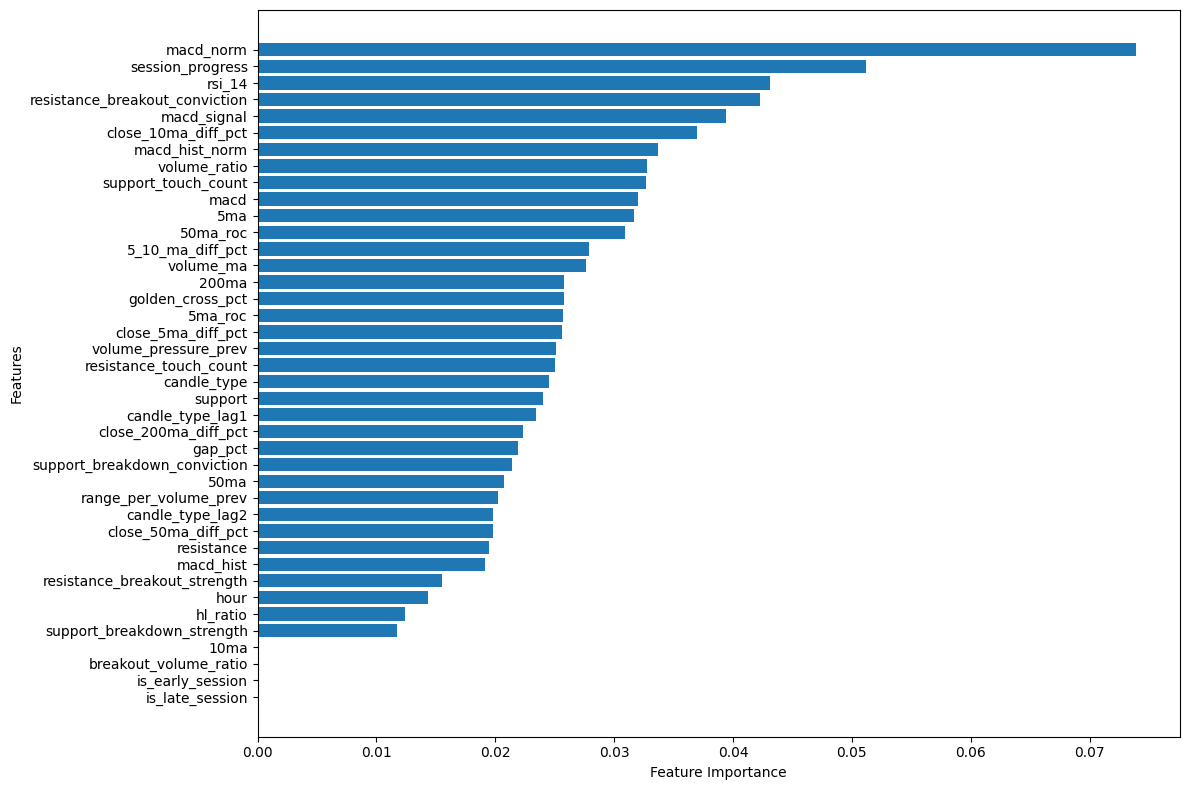

In [962]:
# Extract feature importances
importances = model.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Create a DataFrame for easier manipulation
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=True)

# # Print top features
# print("Top 20 Most Important Features:")
# print(importance_df.head(20))

# Basic histogram
plt.figure(figsize=(12, 8))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [963]:
dump(model, f"./{filename}/{version}.joblib")

['./ADANIPORTS/2025_no_validation_XGB.joblib']